In [19]:
%cd /home/dongmin/23FW-NCG/jeongganbo-omr
%load_ext autoreload
%autoreload 2

/home/dongmin/23FW-NCG/jeongganbo-omr
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
import glob
import cv2
import numpy as np
from data_utils import JeongganboReader
import matplotlib.pyplot as plt

from exp_utils import read_jeongganbo, make_jeonggan_list, JeongganProcessor, COLOR_DICT

# Load ext files and paths

**Daegeum**
* YeoMinRock score (p17~36)
* pitch names
* notations

In [21]:
%%capture
reader = JeongganboReader()

ymr_infos = {
  "name": 'daegeum',
  "start": 17, # page 17 ~ 36
  "num_page": 20
}

ymr = read_jeongganbo(reader, ymr_infos)

jng_list = make_jeonggan_list(reader, ymr)

pattern_path_base = 'test/daegeum/'
# pattern_path_sub = ['notations/', 'pitches/']
pattern_path_sub = ['pitches/']
pattern_ext = '.png'

pattern_paths = { 
  subpath[:-1]: {
    path.replace(f'{pattern_path_base}{subpath}', '').replace(pattern_ext, ''): path \
    for path in glob.glob(f'{pattern_path_base}{subpath}*{pattern_ext}')
  } for subpath in pattern_path_sub 
}

# print([ name for name in pattern_paths['notations'].keys() ])
print([ name for name in pattern_paths['pitches'].keys() ])

In [24]:
target_jng_list = jng_list

# **CONSTANTS**

In [25]:
THRESHOLD = 0.5
MATCH_MODE = cv2.TM_CCOEFF_NORMED
PTRN_SIZE = 47

JNG_INDICES = [0, 4, 43, 161, 286, 289]

PTRN_TEST_ORDER = ['hwang_uu', 'hwang_u', 'hwang', 'joong_u', 'joong', 'lim_u', 'lim_d', 'lim', 'mu_d', 'mu_u', 'mu', 'nam_u', 'nam_d', 'nam', 'tae_u', 'tae']

PNAME_SURFIXS = ['uu, u, d, dd']

PTRN_IMG_DICT = { name: cv2.imread(pattern_paths['pitches'][name]) for name in PTRN_TEST_ORDER }

jng_processor = JeongganProcessor(PTRN_SIZE, THRESHOLD, MATCH_MODE)


In [27]:
color_list = [ color for key, color in list( filter( lambda el: '_d' not in el[0] and '_u' not in el[0], COLOR_DICT.items() ) ) ]

# Piplines

## position alignment logics
**Need to add to JeongganProcessor**

In [28]:
## pipeline logics
def get_match_bbox_groups(img, ptrn_dict):
  bbox_list = [] # list of (tl_x, tl_y, br_x, br_y, confi, ptrn_name)

  for ptrn_key, ptrn_img in ptrn_dict.items():
    # list of (tl_x, tl_y, br_x, br_y, confi)
    bboxs = jng_processor.get_match_bboxs(img, ptrn_img) 
    bboxs_merged = jng_processor.merge_match_bboxs(bboxs)
    
    if( len(bboxs_merged) > 0 ):
      bbox_list += [bbox + (ptrn_key,) for bbox in bboxs_merged]

  # list of [ (tl_x, tl_y, br_x, br_y, confi, ptrn_name) ]
  bbox_groups = jng_processor.group_overlap_match_bboxs(bbox_list)
  
  return bbox_groups
  
def get_contour_bboxs(img, match_bbox_groups):
  cont_bbox_list = []

  for match_bbox_group in match_bbox_groups:
    slice_tl_x, slice_tl_y, slice_br_x, slice_br_y = jng_processor.get_bbox_of_match_bbox_group(img, match_bbox_group)
    img_sliced = img.copy()[slice_tl_y:slice_br_y, slice_tl_x:slice_br_x]
    
    cont_bbox_sliced, *_ = jng_processor.find_contour_bbox(img_sliced)
    
    cont_bbox = tuple(el + slice_tl_x if idx%2 == 0 else el + slice_tl_y for idx, el in enumerate(cont_bbox_sliced))
    
    cont_bbox_list.append(cont_bbox)
  
  return cont_bbox_list

## contour box grouping logics
def get_bbox_center_y(box):
  _, tl_y, _, br_y, *_ = box
  return tl_y + (br_y - tl_y)//2

def is_approximate_contour_bbox(target, compare, max_dist=5):  
  t_center_y = get_bbox_center_y(target)
  c_center_y = get_bbox_center_y(compare)
  
  return abs(t_center_y - c_center_y) < max_dist

def get_y_approximates_contour_bbox(boxs, target_box, target_idx, max_dist=5):
  approxs = []
  for idx, box in enumerate(boxs):
    if idx > target_idx and is_approximate_contour_bbox(target_box, box, max_dist):
      approxs.append( (box, idx) )
  return approxs

def group_contour_bboxs_by_ypos(bboxs, max_dist=5):
  bboxs = sorted(bboxs, key=lambda b: b[1])

  bbox_groups = []
  index = 0

  while True:
    if index > len(bboxs) - 1:
      break
    
    curr = bboxs[index]

    # overlapping box indexs
    approxs = get_y_approximates_contour_bbox(bboxs, curr, index, max_dist=max_dist)

    if len(approxs) > 0:
      approx_boxs = [ tup[0] for tup in approxs ]
      approx_boxs = [curr] + approx_boxs
      
      bbox_groups.append( approx_boxs )
      
      # remove approxs
      approx_indices = [ tup[1] for tup in approxs ]
      
      approx_indices.sort(reverse=True)
      for approx_idx in approx_indices:
        assert approx_idx < len(bboxs), f'index out of range: {approx_idx} / {len(bboxs) - 1}' 
        del bboxs[approx_idx]
        
    else:
      bbox_groups.append( [curr] )

    index += 1

  return bbox_groups

def get_bbox_group_center_y(bbox_group):
  bbox_center_ys = [ get_bbox_center_y(bbox) for bbox in bbox_group]
  return round(np.mean(bbox_center_ys))

## position template align logics
def get_position_templates(img_dims):
  img_h, img_w = img_dims
  row_templates = [ tuple(img_h//idx * jdx for jdx in range(1, idx)) for idx in range(2, 5) ]
  col_templates = [ tuple(img_w//idx * jdx for jdx in range(1, idx)) for idx in range(2, 4) ]
  
  return row_templates, col_templates

def check_white_space(img, box, max_pix=300):
  img = img.copy()
  
  img_sliced = np.concatenate((img[:box[1]], img[box[3]:]), axis=0)
  img_sliced = np.where( cv2.cvtColor(img_sliced, cv2.COLOR_BGR2GRAY) > 230, 0, 1 )
  
  return np.sum(img_sliced) < max_pix 

def get_aligned_row_indices(img, groups, templates, max_dist=5):
  fit_result_list = []
  
  for template_idx, template in enumerate(templates):
    fit_result = 0
    row_matching_result = [None] * (template_idx + 1)
    
    if len(groups) > len(template):
      fit_result_list.append( (fit_result, template_idx + 1, row_matching_result) )
      continue
    
    last_group_idx = 0
    
    for row_idx, row_pos in enumerate(template):
      group_idx = 0
      
      while True:
        if group_idx > len(groups) - 1:
          break
        
        if group_idx < last_group_idx:
          group_idx += 1
          continue
        
        curr_group = groups[group_idx]
        group_center = curr_group['center']
        
        is_approx = abs(group_center - row_pos) <= max_dist
        if len(template) > 2 and row_idx in (0, 2):
          is_approx = is_approx or (row_idx == 0 and group_center < row_pos)
          is_approx = is_approx or (row_idx == 2 and group_center > row_pos)
        
        if is_approx:
          fit_result += 1
          row_matching_result[row_idx] = group_idx
          last_group_idx = group_idx
          break
        
        group_idx += 1

    fit_result_list.append( (fit_result, template_idx + 1, row_matching_result) )

  if len(groups) == 1 and fit_result_list[0][0] == fit_result_list[2][0] and check_white_space(img, groups[0]['group'][0]):
    return fit_result_list[0][1:]
  
  return max(fit_result_list, key=lambda x: x[0])[1:]

def get_aligned_col_indices(group, templates, max_dist=5):
  fit_result_list = []
  
  for template_idx, template in enumerate(templates):
    fit_result = 0
    col_matching_result = [None]* (template_idx + 1)
    
    last_char_idx = 0
    
    for col_idx, col_pos in enumerate(template):
      char_idx = 0
      
      while True:
        if char_idx > len(group) - 1:
          break
        
        if char_idx < last_char_idx:
          char_idx += 1
          continue
        
        curr_char = group[char_idx]
        char_center = curr_char[0] + (curr_char[2] - curr_char[0])//2
        
        is_approx = abs(char_center - col_pos) <= max_dist
        if len(template) > 1:
          is_approx = is_approx or (col_idx == 0 and char_center < col_pos)
          is_approx = is_approx or (col_idx == 1 and char_center > col_pos)
        
        if is_approx:
          fit_result += 1
          col_matching_result[col_idx] = char_idx
          last_char_idx = char_idx
          break
        
        char_idx += 1
        
    fit_result_list.append( (fit_result, template_idx + 1, col_matching_result) )
    
  return max(fit_result_list, key=lambda x: x[0])[1:]

## test: alignment logics

20 th jng has...
total num matches:  2
total num rows:  3
0 {'col_div': 1, 'cols': [(30, 5, 74, 41)]}
1 {'col_div': 1, 'cols': [(32, 45, 71, 82)]}
2 None


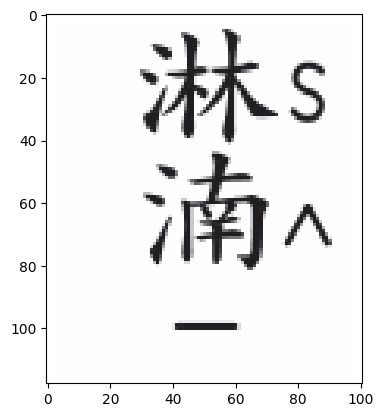

24 th jng has...
total num matches:  3
total num rows:  3
0 {'col_div': 1, 'cols': [(33, 7, 75, 40)]}
1 {'col_div': 1, 'cols': [(31, 45, 72, 81)]}
2 {'col_div': 2, 'cols': [None, (57, 79, 97, 116)]}


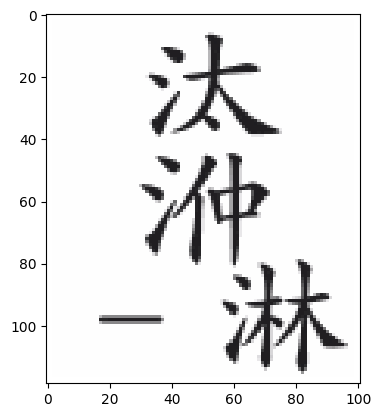

43 th jng has...
total num matches:  3
total num rows:  3
0 {'col_div': 2, 'cols': [(15, 7, 53, 44), (54, 8, 91, 41)]}
1 None
2 {'col_div': 1, 'cols': [(30, 77, 72, 114)]}


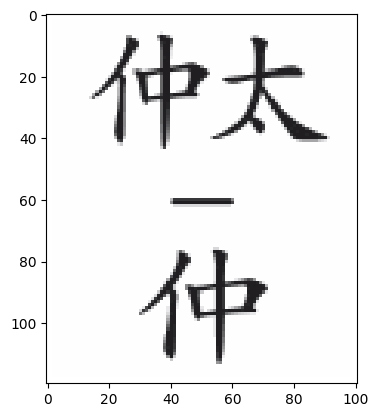

72 th jng has...
total num matches:  1
total num rows:  1
0 {'col_div': 1, 'cols': [(30, 35, 77, 78)]}


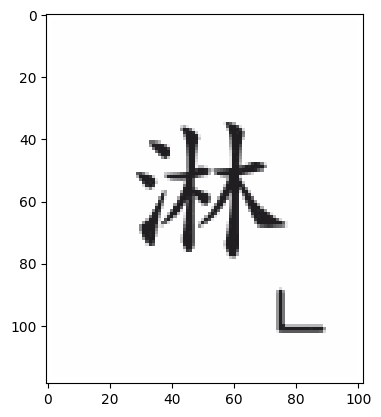

87 th jng has...
total num matches:  2
total num rows:  3
0 {'col_div': 2, 'cols': [(7, 5, 40, 43), (47, 7, 86, 40)]}
1 None
2 None


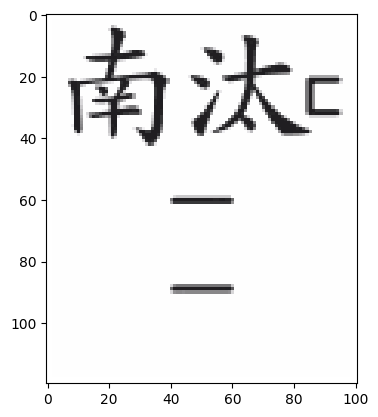

134 th jng has...
total num matches:  2
total num rows:  3
0 {'col_div': 1, 'cols': [(33, 7, 75, 40)]}
1 {'col_div': 1, 'cols': [(31, 45, 72, 81)]}
2 None


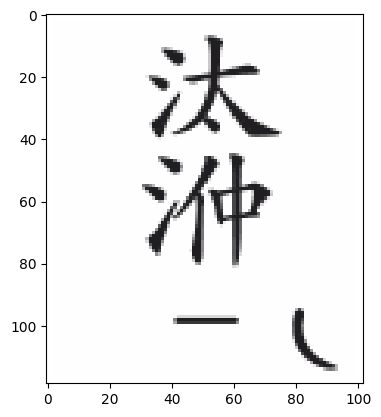

135 th jng has...
total num matches:  2
total num rows:  3
0 {'col_div': 1, 'cols': [(33, 8, 75, 41)]}
1 {'col_div': 1, 'cols': [(32, 44, 74, 81)]}
2 None


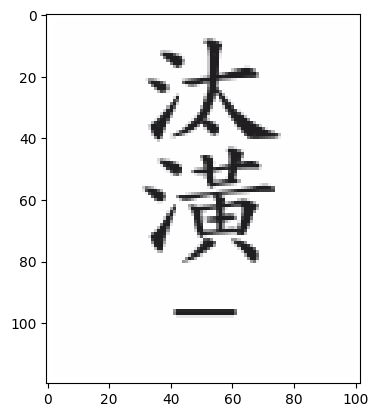

161 th jng has...
total num matches:  3
total num rows:  3
0 {'col_div': 1, 'cols': [(36, 5, 72, 43)]}
1 {'col_div': 1, 'cols': [(34, 43, 78, 79)]}
2 {'col_div': 1, 'cols': [(36, 78, 72, 116)]}


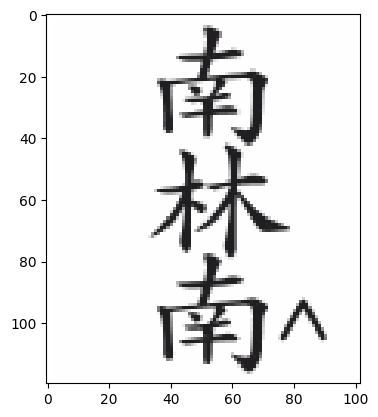

167 th jng has...
total num matches:  2
total num rows:  3
0 {'col_div': 1, 'cols': [(32, 5, 75, 42)]}
1 {'col_div': 2, 'cols': [None, (52, 46, 89, 79)]}
2 None


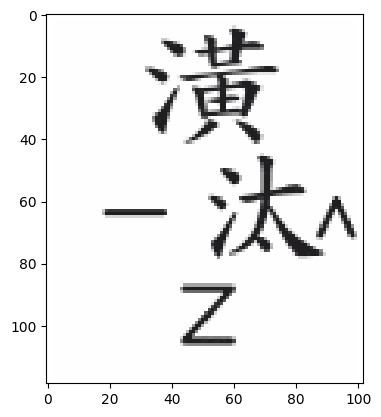

261 th jng has...
total num matches:  1
total num rows:  3
0 None
1 None
2 {'col_div': 1, 'cols': [(35, 76, 71, 114)]}


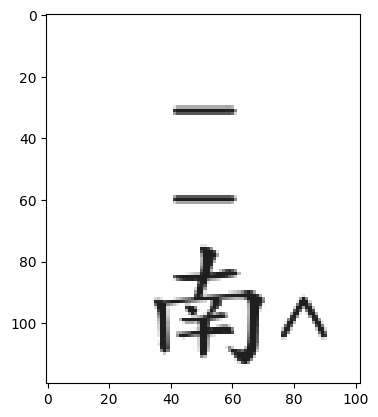

286 th jng has...
total num matches:  3
total num rows:  3
0 {'col_div': 1, 'cols': [(31, 5, 75, 42)]}
1 None
2 {'col_div': 2, 'cols': [(13, 73, 46, 111), (51, 74, 92, 111)]}


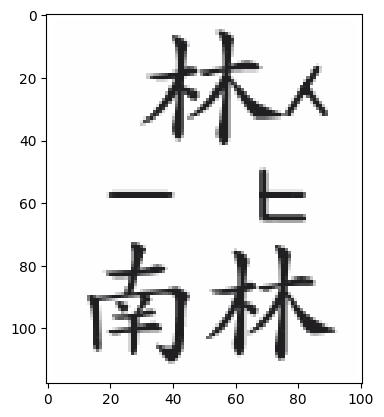

289 th jng has...
total num matches:  3
total num rows:  3
0 {'col_div': 1, 'cols': [(31, 5, 74, 42)]}
1 {'col_div': 2, 'cols': [None, (52, 35, 88, 75)]}
2 {'col_div': 1, 'cols': [(32, 78, 74, 115)]}


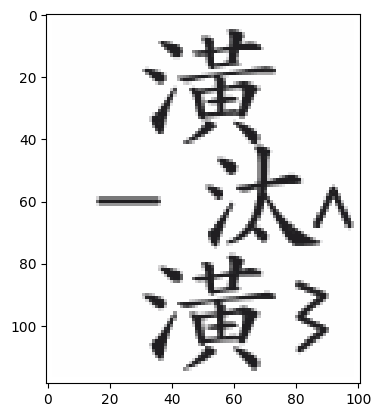

In [29]:
test_jng_idxs = [20, 24, 43, 72, 87, 134, 135, 161, 167, 261, 286, 289]
for iter_idx, jng_idx in enumerate(test_jng_idxs):
  jng_img = jng_processor.remove_borders( target_jng_list[jng_idx] )

  row_templates, col_templates = get_position_templates(jng_img.shape[:2])

  jng_match_bbox_groups = get_match_bbox_groups(jng_img, PTRN_IMG_DICT)
  jng_cont_bboxs = get_contour_bboxs(jng_img, jng_match_bbox_groups)
  jng_cont_bbox_groups = group_contour_bboxs_by_ypos(jng_cont_bboxs, max_dist=5)
  jng_row_groups = [ { 'center': get_bbox_group_center_y(group), 'group': sorted(group, key=lambda x: x[0]) } for group in jng_cont_bbox_groups ]
  jng_row_groups = sorted(jng_row_groups, key=lambda x: x['center'])
  
  row_div, row_indices = get_aligned_row_indices(jng_img, jng_row_groups, row_templates)
  
  jng_aligned_result = { 
    'row_div': row_div,
    'rows': [None] * row_div
  }
  
  for row_idx, jng_row_group_idx in enumerate(row_indices):
    if jng_row_group_idx == None:
      continue
    
    jng_row_group = jng_row_groups[jng_row_group_idx]['group']
    col_div, col_indices = get_aligned_col_indices(jng_row_group, col_templates)
    
    jng_aligned_result['rows'][row_idx] = {
      'col_div': col_div,
      'cols': [ jng_row_group[char_idx] if char_idx != None else char_idx for char_idx in col_indices]
    }

  print(f'{jng_idx} th jng has...')
  print('total num matches: ', len(jng_match_bbox_groups))
  print('total num rows: ', jng_aligned_result['row_div'])
  
  for row_idx, row in enumerate(jng_aligned_result['rows']):
    print(row_idx, row)
  
  plt.imshow(jng_img)
  plt.show()